In [1]:
import flaremodel as fm
import numpy as np
import matplotlib.pyplot as plt
fm.set_rcparams(fs=15)

In [2]:
sgrA = fm.SgrA()

def radius_from_projected(R_proj):
    """
    Return source radius from projected radius

    Parameters
    ----------
    R_proj : float
        Projected radius in uas.
    """
    return sgrA.distance*(R_proj*np.pi/648e9)


In [3]:
class ThermalSync(fm.SEDFitLM):
    
    def __init__(self, data, p0, bounds_l=None, bounds_h=None,
                                vary=None, params=None):

        self.param_names = ["log10_ne", "R_proj", "B", "theta_E"]
        super().__init__(data, p0=p0, bounds_l=bounds_l, bounds_h=bounds_h, vary=vary, params=params)
        
        
    def set_models(self):
        self.models = []
        self.flare = fm.HomogeneousSphere(edist="thermal")
        
        self.models.append(lambda nu, p : 
                           self.flare.compute_synchrotron(nu, 10**p["log10_ne"], 
                                        [radius_from_projected(p["R_proj"]), -1], 
                                        p['B'], [p['theta_E']])) 

In [4]:
sgrA = fm.SgrA()
data = [[sgrA.submmSED[0], sgrA.submmSED[1], sgrA.submmSED[2]]]
p0 =       [5.5, 40., 10., 30.]
bounds_l = [4, 30, 1, 5]
bounds_h = [10, 50, 300, 1000]
vary=      [True, True, True, True]

In [5]:
submm = ThermalSync(data=data, p0=p0, vary=vary, bounds_l=bounds_l, bounds_h=bounds_h)
submm.params

name,value,initial value,min,max,vary
log10_ne,5.50000000,5.5,4.00000000,10.0000000,True
R_proj,40.0000000,40.0,30.0000000,50.0000000,True
B,10.0000000,10.0,1.00000000,300.000000,True
theta_E,30.0000000,30.0,5.00000000,1000.00000,True


Text(0.5, 0, 'Frequency [Hz]')

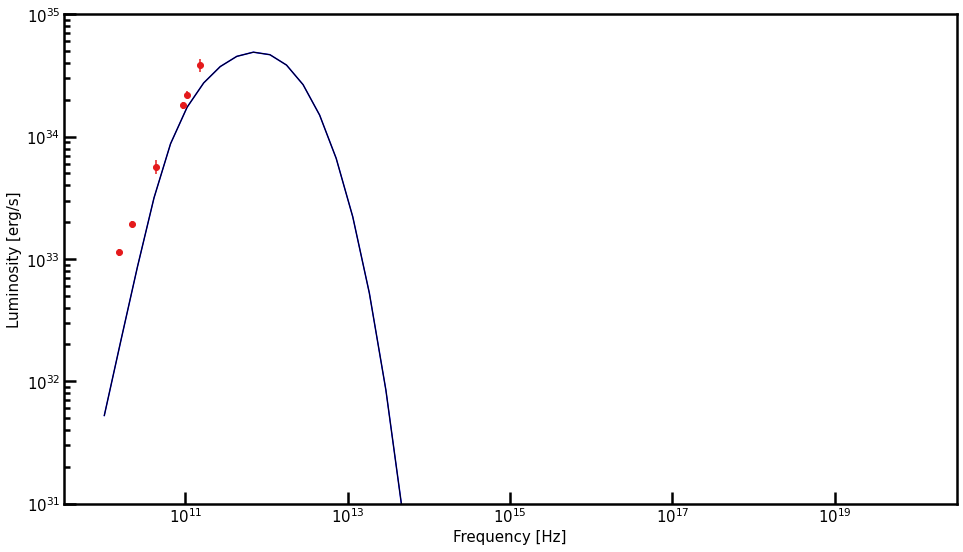

In [6]:
submm.plot_initial_guess(ylim=[1e31, 1e35], show=False)
plt.ylabel("Luminosity [erg/s]")
plt.xlabel("Frequency [Hz]")

[[Variables]]
    log10_ne:  5.05268927 +/- 1.06568127 (21.09%) (init = 5.5)
    R_proj:    45.4387726 +/- 2.48467967 (5.47%) (init = 40)
    B:         25.0314694 +/- 79.5735308 (317.89%) (init = 10)
    theta_E:   103.734801 +/- 2.21192395 (2.13%) (init = 30)


red. Chi^2: 14.023246080016753


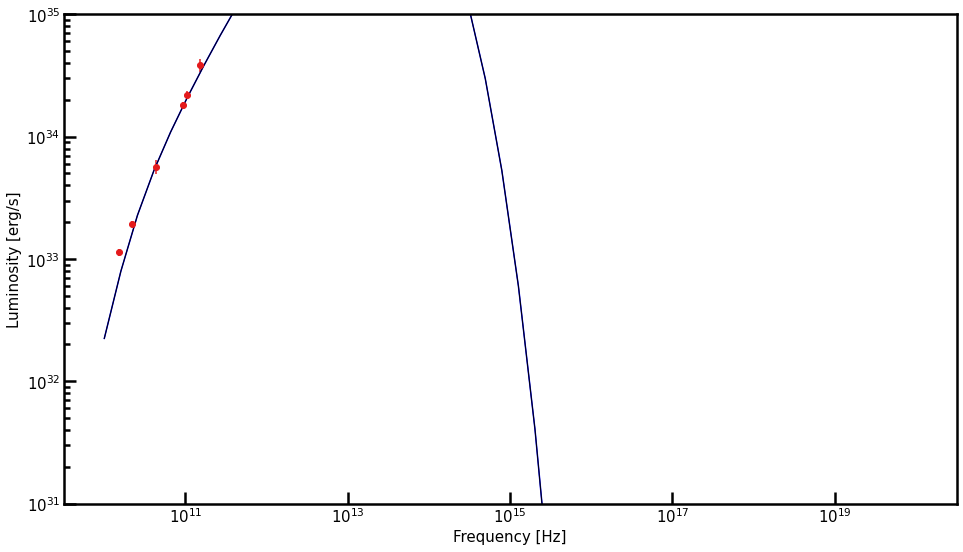

In [7]:
submm.fit()
submm.plot_fit(ylim=(1e31, 1e35), show=False)
plt.ylabel("Luminosity [erg/s]")
plt.xlabel("Frequency [Hz]")
submm.report_fit(show_correl=False)

In [8]:
get_theta_E = lambda T_e: T_e*fm.k_b/(fm.M_e*fm.c**2)
te = get_theta_E(1.5e11)
p0 =       [5.5, 40., 30, te]
bounds_l = [4, 30, 1, 5]
bounds_h = [10, 50, 300, 1000]
vary=      [True, False, True, False]

In [9]:
submm = ThermalSync(data=data, p0=p0, vary=vary, bounds_l=bounds_l, bounds_h=bounds_h)

In [10]:
submm.fit()
submm.report_fit(show_correl=False)

[[Variables]]
    log10_ne:  5.02526840 +/- 0.94451789 (18.80%) (init = 5.5)
    R_proj:    40 (fixed)
    B:         39.6753007 +/- 76.4450283 (192.68%) (init = 30)
    theta_E:   25.29259 (fixed)


red. Chi^2: 52.91853376430094


In [11]:
geo = fm.HomogeneousSphere(edist="thermal")
params = submm.MinimizerResult.params
nus = np.logspace(10, 20, 100)
ssc = geo.compute_SSC(nus, 10**params["log10_ne"],
                             [radius_from_projected(params["R_proj"]), -1], 
                            params["B"], [params["theta_E"]])

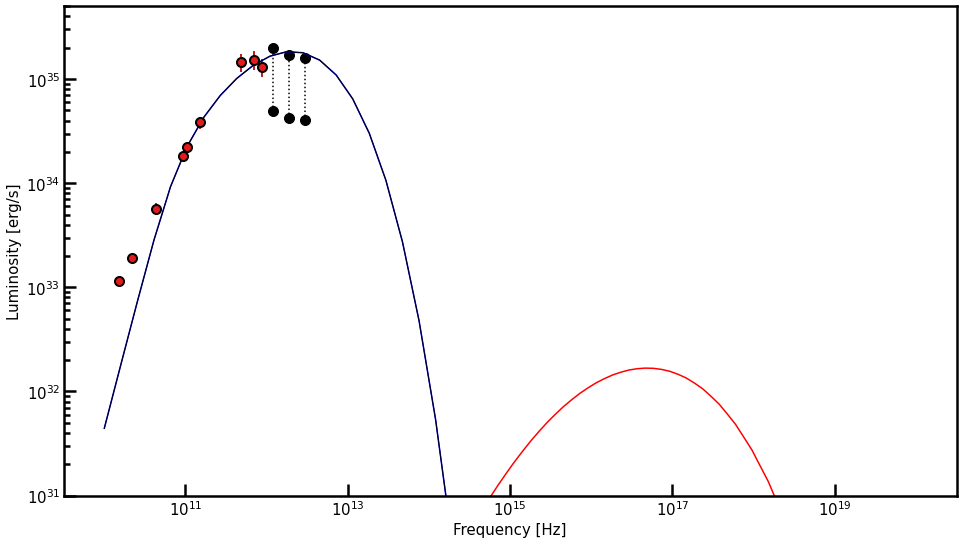

In [12]:
fig, ax = plt.subplots()
ax.plot(sgrA.submmSED[0], sgrA.submmSED[1],"o", color="black")
ax.errorbar(sgrA.submmSED[0], sgrA.submmSED[1], sgrA.submmSED[2], fmt="o", ms=10, color="black")
ax.loglog(sgrA.firSED[0], sgrA.firSED[1], "o", color="black", ms=10)
ax.loglog([sgrA.firSED[0][0], sgrA.firSED[0][0]], [sgrA.firSED[1][0], sgrA.firSED[1][3]] , ":", color="black", )
ax.loglog([sgrA.firSED[0][1], sgrA.firSED[0][1]], [sgrA.firSED[1][1], sgrA.firSED[1][4]] , ":", color="black", )
ax.loglog([sgrA.firSED[0][2], sgrA.firSED[0][2]], [sgrA.firSED[1][2], sgrA.firSED[1][5]] , ":", color="black", )
ax.loglog(nus, ssc*nus, "r-")

ax.set_ylabel("Luminosity [erg/s]")
ax.set_xlabel("Frequency [Hz]")
    
submm.plot_fit(ax=ax, ylim=[1e31, 5e35])